<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/CNN_Multiclass_FileUpload_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=30ddea37538d977027fc922d8997d9a870cf144f6f447fedf4eba756c36ad543
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [2]:
!pip install kaggle

In [3]:
!cp /content/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip train.zip

In [2]:
import os
import zipfile
import pandas as pd

In [3]:
base_dir = '/content/'
train_dir = os.path.join(base_dir, 'train')
train_img_names = os.listdir(train_dir)

dog = list()
cat = list()
for image in train_img_names:
    category = image.split(".")[0]
    if category == "dog":
        dog.append("1")
        cat.append("0")
    else:
        cat.append("1")
        dog.append("0")
df= pd.DataFrame({"fname":train_img_names, "Dog": dog, "Cat": cat})

df.head()

,fname,Dog,Cat
0,dog.12447.jpg,1,0
1,cat.245.jpg,0,1
2,dog.4133.jpg,1,0
3,cat.6425.jpg,0,1
4,dog.8869.jpg,1,0


In [4]:
from sklearn.model_selection import train_test_split
train,validation= train_test_split(df, test_size=0.3)
train = train.reset_index(drop=True) 
validation = validation.reset_index(drop=True)
train.to_csv("train_label.csv", index=False)
validation.to_csv("test_label.csv", index=False)
train.shape, validation.shape

((17500, 3), (7500, 3))

In [5]:
from sklearn.model_selection import train_test_split
train,validation= train_test_split(validation, test_size=0.2)
train = train.reset_index(drop=True) 
validation = validation.reset_index(drop=True)
train.to_csv("train_label.csv", index=False)
validation.to_csv("test_label.csv", index=False)
train.shape, validation.shape

((6000, 3), (1500, 3))

In [ ]:
z = 1
for x in train.values:
  print(f"gambar: {z} - {x[0]}")
  category = x[0].split(".")[0]
  if category == 'dog':
    !mv /content/train/{x[0]} /content/train_asu/dog/
  else:
    !mv /content/train/{x[0]} /content/train_asu/cat/
    z+=1

In [9]:
os.makedirs('/content/train_asu/cat/')

In [12]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block
from jcopdl.utils.dataloader import MultilabelDataset

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
bs = 128
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize(135),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
    ])

train_set = datasets.ImageFolder("/content/train_asu/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("/content/test_asu/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [14]:
label2cat = train_set.classes
label2cat

['cat', 'dog']

In [20]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 128, 128])

In [21]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
          conv_block(3, 8),
          conv_block(8, 16),
          conv_block(16, 32),
          conv_block(32, 64),
          conv_block(64, 128),
          nn.Flatten()
      )
    self.fc = nn.Sequential(
          linear_block(128*4*4, 256, dropout=0.2), #1024 dapet dari 64x4x4
          linear_block(256, 2, activation='lsoftmax')
      )
  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [22]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

In [26]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=4, plot_every=10, outdir='model')

In [27]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 0.6930 | Test_cost  = 0.6911 | Train_score = 0.5150 | Test_score = 0.5453 |




Epoch     2
Train_cost  = 0.6858 | Test_cost  = 0.6856 | Train_score = 0.5575 | Test_score = 0.5613 |




Epoch     3
Train_cost  = 0.6773 | Test_cost  = 0.6774 | Train_score = 0.5803 | Test_score = 0.5647 |




Epoch     4
Train_cost  = 0.6638 | Test_cost  = 0.6621 | Train_score = 0.5997 | Test_score = 0.5953 |




Epoch     5
Train_cost  = 0.6556 | Test_cost  = 0.6565 | Train_score = 0.6105 | Test_score = 0.6060 |




Epoch     6
Train_cost  = 0.6449 | Test_cost  = 0.6531 | Train_score = 0.6277 | Test_score = 0.6133 |




Epoch     7
Train_cost  = 0.6265 | Test_cost  = 0.5912 | Train_score = 0.6535 | Test_score = 0.6747 |




Epoch     8
Train_cost  = 0.5998 | Test_cost  = 0.5962 | Train_score = 0.6753 | Test_score = 0.6820 |




Epoch     9
Train_cost  = 0.5740 | Test_cost  = 0.5735 | Train_score = 0.7018 | Test_score = 0.6940 |




Epoch    10
Train_cost  = 0.5562 | Test_cost  = 0.5457 | Train_score = 0.7152 | Test_score = 0.7173 |


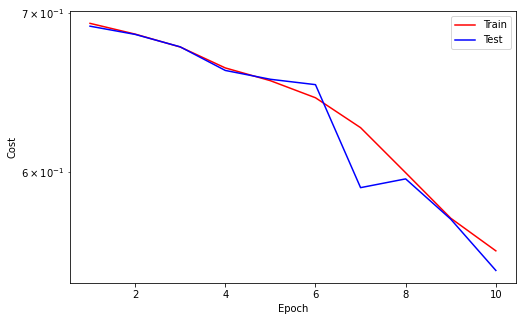

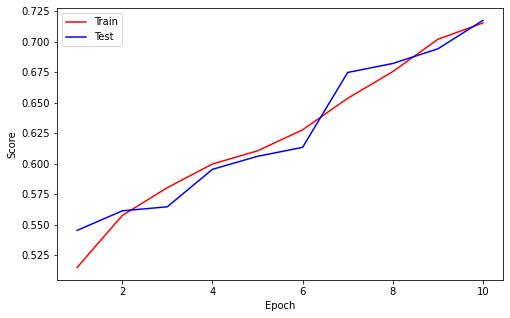



Epoch    11
Train_cost  = 0.5331 | Test_cost  = 0.5414 | Train_score = 0.7323 | Test_score = 0.7200 |




Epoch    12
Train_cost  = 0.5113 | Test_cost  = 0.5221 | Train_score = 0.7458 | Test_score = 0.7353 |




Epoch    13
Train_cost  = 0.5012 | Test_cost  = 0.5482 | Train_score = 0.7550 | Test_score = 0.7147 |
==> EarlyStop patience =  1 | Best test_score: 0.7353




Epoch    14
Train_cost  = 0.4882 | Test_cost  = 0.5093 | Train_score = 0.7625 | Test_score = 0.7387 |




Epoch    15
Train_cost  = 0.4721 | Test_cost  = 0.4980 | Train_score = 0.7733 | Test_score = 0.7500 |




Epoch    16
Train_cost  = 0.4736 | Test_cost  = 0.4978 | Train_score = 0.7693 | Test_score = 0.7560 |




Epoch    17
Train_cost  = 0.4527 | Test_cost  = 0.5453 | Train_score = 0.7905 | Test_score = 0.7227 |
==> EarlyStop patience =  1 | Best test_score: 0.7560




Epoch    18
Train_cost  = 0.4449 | Test_cost  = 0.4654 | Train_score = 0.7893 | Test_score = 0.7853 |




Epoch    19
Train_cost  = 0.4259 | Test_cost  = 0.4551 | Train_score = 0.8035 | Test_score = 0.7880 |




Epoch    20
Train_cost  = 0.4143 | Test_cost  = 0.4461 | Train_score = 0.8092 | Test_score = 0.7773 |


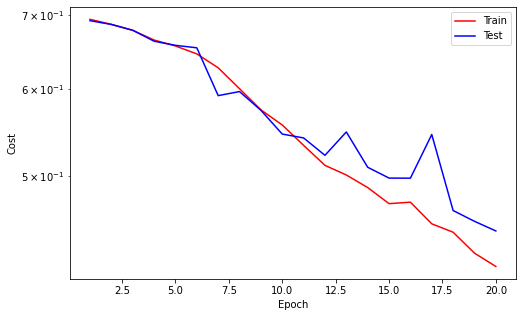

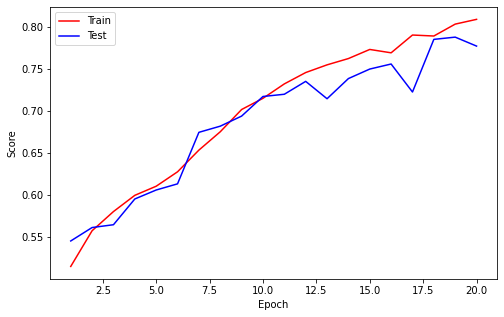

==> EarlyStop patience =  1 | Best test_score: 0.7880




Epoch    21
Train_cost  = 0.4036 | Test_cost  = 0.4399 | Train_score = 0.8202 | Test_score = 0.7820 |
==> EarlyStop patience =  2 | Best test_score: 0.7880




Epoch    22
Train_cost  = 0.4036 | Test_cost  = 0.4609 | Train_score = 0.8155 | Test_score = 0.7780 |
==> EarlyStop patience =  3 | Best test_score: 0.7880




Epoch    23
Train_cost  = 0.3901 | Test_cost  = 0.4337 | Train_score = 0.8202 | Test_score = 0.7973 |




Epoch    24
Train_cost  = 0.3762 | Test_cost  = 0.4325 | Train_score = 0.8313 | Test_score = 0.7947 |
==> EarlyStop patience =  1 | Best test_score: 0.7973




Epoch    25
Train_cost  = 0.3765 | Test_cost  = 0.4207 | Train_score = 0.8283 | Test_score = 0.8127 |




Epoch    26
Train_cost  = 0.3533 | Test_cost  = 0.4165 | Train_score = 0.8412 | Test_score = 0.8107 |
==> EarlyStop patience =  1 | Best test_score: 0.8127




Epoch    27
Train_cost  = 0.3620 | Test_cost  = 0.4252 | Train_score = 0.8407 | Test_score = 0.7940 |
==> EarlyStop patience =  2 | Best test_score: 0.8127




Epoch    28
Train_cost  = 0.3444 | Test_cost  = 0.4318 | Train_score = 0.8503 | Test_score = 0.7993 |
==> EarlyStop patience =  3 | Best test_score: 0.8127




Epoch    29
Train_cost  = 0.3419 | Test_cost  = 0.4689 | Train_score = 0.8487 | Test_score = 0.7860 |
==> EarlyStop patience =  4 | Best test_score: 0.8127
==> Execute Early Stopping at epoch: 29 | Best test_score: 0.8127
==> Best model is saved at model


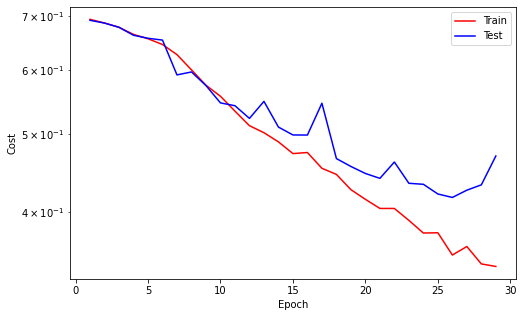

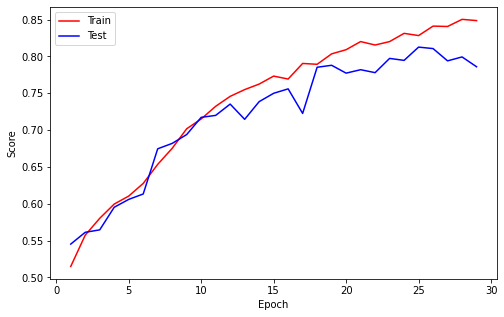

In [28]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [33]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1])

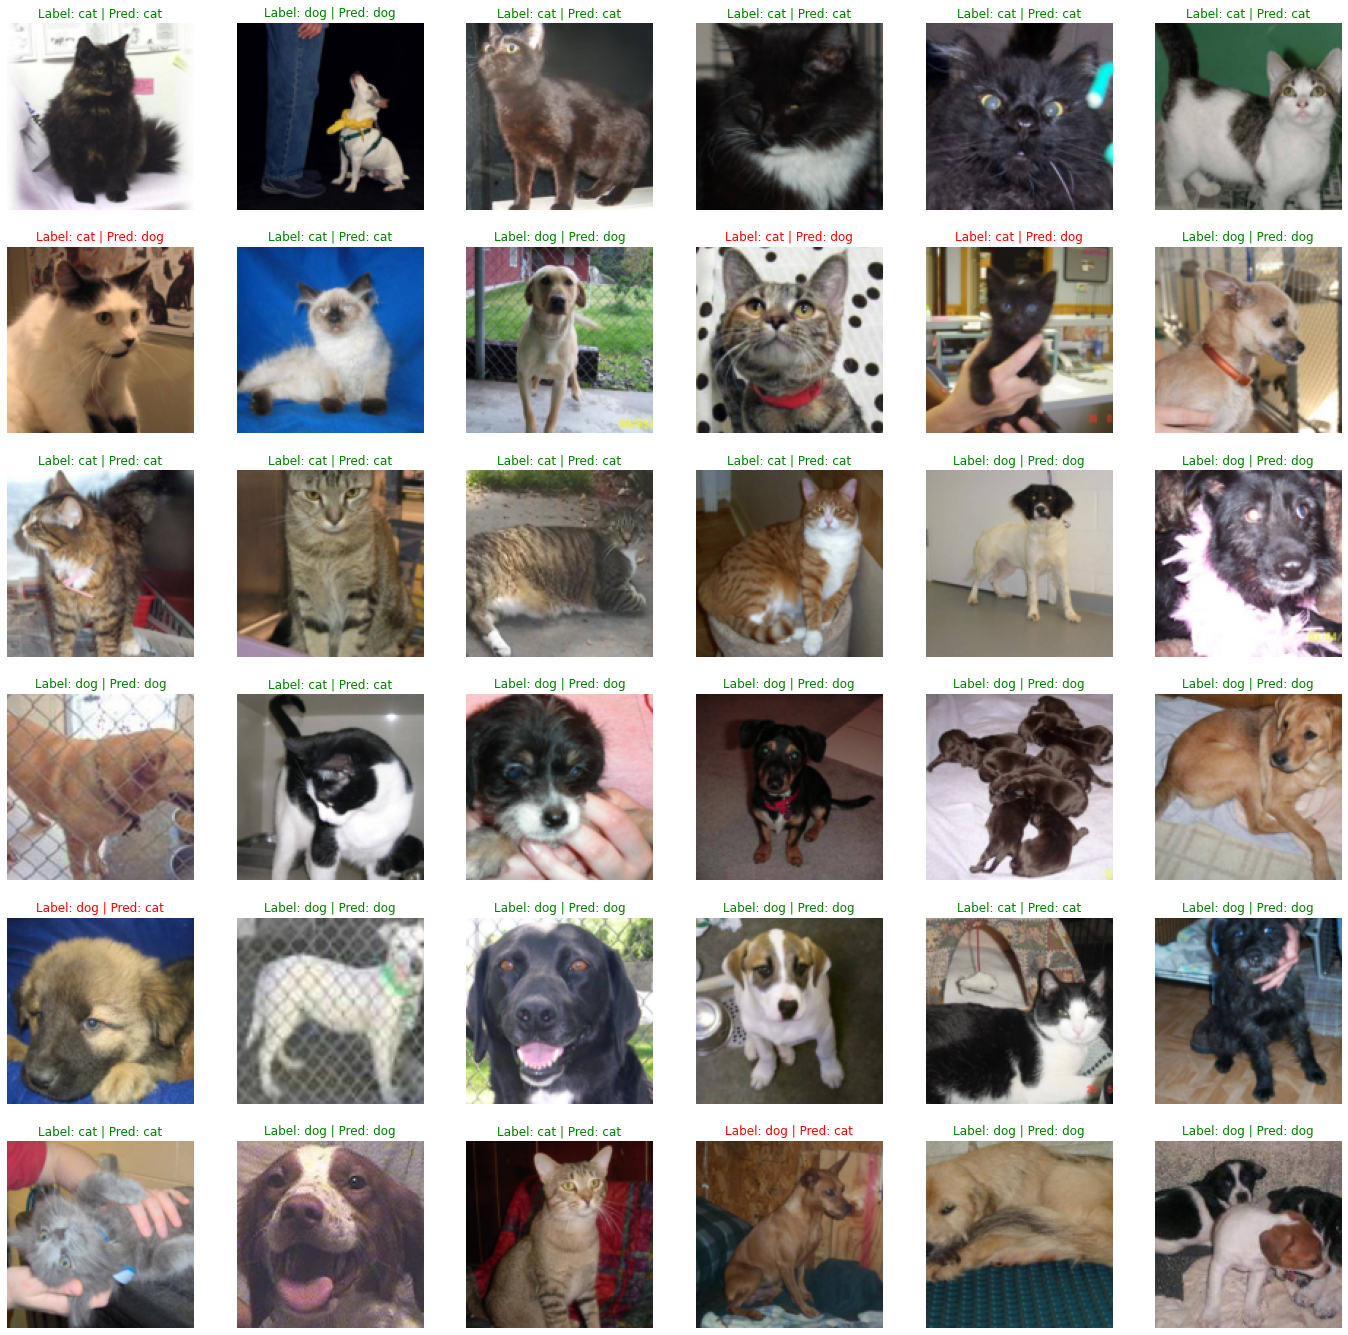

In [34]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
  ax.axis("off");

In [35]:
from PIL import Image

In [49]:
loader = transforms.Compose([transforms.Resize(135),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

image = image_loader("/content/test_asu/cat/cat.1026.jpg")
with torch.no_grad():
  model.eval()
  output = model(image)
  prediksi = output.argmax(1)
  print(label2cat[prediksi])

cat
